# Classificazione del data set Titanic con Sci-kit Learn

Caricheremo il data set utilizzando un datafrme Pandas e ne faremo l'analisi e l'imputazione dei valori mancanti. Ne seguirà il ranking delle feature più rilevanti e la classificazione.
Infine, faremo l'analisi dei risultati con le metriche di accuracy, AUC e AUPRC.

In [38]:
# Definiamo qui tutti gli import necessari

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex
from sklearn.preprocessing import OrdinalEncoder
from skfeature.function.similarity_based.fisher_score import fisher_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, log_loss, make_scorer, RocCurveDisplay

# definiamo il percorso della cartella dei dati
# Ognuno inserirà qui il percorso per la cartella dell'esercitazione
DATA_HOME = '/home/rpirrone/'

Leggiamo i due data set e guardiamo le informazioni sugli schemi e sugli elementi nulli

In [39]:
train_data = pd.read_csv(DATA_HOME+'data/train.csv',index_col=0)

train_data.info()

train_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
test_data = pd.read_csv('/home/rpirrone/data/test.csv',index_col=0)

test_data.info()

test_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Imputazione dei valori mancanti

Dalla prima ispezione la feature `Cabin` è molto sparsa e la eliminiamo.

In [41]:
train_data.drop('Cabin',axis=1,inplace=True)
train_data.info()

test_data.drop('Cabin',axis=1,inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    in

Uniamo i due dataframe per l'imputazione degli altri dati in `Age` e `Embarked` (solo nel test set)

In [42]:
all_data = pd.concat([train_data, test_data])

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 112.5+ KB


Calcoliamo la massima etichetta ricorrente della feature `Embarked`. Dopo il `GroupBy` sulla feature, contiamo i valori e selezioniamo per comodità solo la colonna `Pclass`da cui ci facciamo ritornare l'indice del valor massimo.

In [43]:
train_data['Embarked'].fillna(all_data.groupby('Embarked')\
                                    .count()['Pclass']\
                                    .idxmax(),\
                                    inplace=True)


Aggiungiamo al dataframe globale una colonna contenente i titoli dei passeggeri, estratti dalla colonna `Name` tramite espressione regolare e poi calcoliamo le età medie per ogni titolo per fare l'imputazione in `Age`.
I titoli rispecchiavano fasce di età ben precise.

In [44]:
all_data.insert(3,'Initial',all_data['Name'].apply(lambda x: regex.search(r'.*, (.*?)\..*',x).group(1)))


In [45]:
all_data

,Survived,Pclass,Name,Initial,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",Mr,male,22.0,1,0,A/5 21171,7.2500,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,female,38.0,1,0,PC 17599,71.2833,C
3,1.0,3,"Heikkinen, Miss. Laina",Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,female,35.0,1,0,113803,53.1000,S
5,0.0,3,"Allen, Mr. William Henry",Mr,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",Mr,male,NaN,0,0,A.5. 3236,8.0500,S
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",Dona,female,39.0,0,0,PC 17758,108.9000,C
1307,NaN,3,"Saether, Mr. Simon Sivertsen",Mr,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S


Creiamo la tabella pivot delle età medie per titolo.

In [46]:
avg_age = pd.DataFrame(all_data.groupby(['Initial'])['Age'].mean())

avg_age.rename(columns={'Age': 'Avg_age'})

,Avg_age
Initial,
Capt,70.000000
Col,54.000000
Don,40.000000
Dona,39.000000
Dr,43.571429
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,5.482642


Creiamo la colonna `Initial` anche nel training set e nel test set e poi ne faremo il join con il dataframe pivot al fine di fare l'imputazione nei due data set.

In [47]:
train_data.insert(3,'Initial',all_data['Name'].apply(lambda x: regex.search(r'.*, (.*?)\..*',x).group(1)))

test_data.insert(3,'Initial',all_data['Name'].apply(lambda x: regex.search(r'.*, (.*?)\..*',x).group(1)))

In [48]:
train_data = train_data.join(avg_age,how='inner',on='Initial',rsuffix='_avg')
train_data

,Survived,Pclass,Name,Initial,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_avg
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",Mr,male,22.0,1,0,A/5 21171,7.2500,S,32.252151
5,0,3,"Allen, Mr. William Henry",Mr,male,35.0,0,0,373450,8.0500,S,32.252151
6,0,3,"Moran, Mr. James",Mr,male,NaN,0,0,330877,8.4583,Q,32.252151
7,0,1,"McCarthy, Mr. Timothy J",Mr,male,54.0,0,0,17463,51.8625,S,32.252151
13,0,3,"Saundercock, Mr. William Henry",Mr,male,20.0,0,0,A/5. 2151,8.0500,S,32.252151
...,...,...,...,...,...,...,...,...,...,...,...,...
648,1,1,"Simonius-Blumer, Col. Oberst Alfons",Col,male,56.0,0,0,13213,35.5000,C,54.000000
695,0,1,"Weir, Col. John",Col,male,60.0,0,0,113800,26.5500,S,54.000000
746,0,1,"Crosby, Capt. Edward Gifford",Capt,male,70.0,1,1,WE/P 5735,71.0000,S,70.000000


In [49]:
train_data['Age'].fillna(train_data['Age_avg'],inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 823
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Initial   891 non-null    object 
 4   Sex       891 non-null    object 
 5   Age       891 non-null    float64
 6   SibSp     891 non-null    int64  
 7   Parch     891 non-null    int64  
 8   Ticket    891 non-null    object 
 9   Fare      891 non-null    float64
 10  Embarked  891 non-null    object 
 11  Age_avg   891 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 90.5+ KB


In [50]:
train_data.drop('Age_avg',axis=1,inplace=True)

# ripetiamo per test_data
test_data = test_data.join(avg_age,how='inner',on='Initial',rsuffix='_avg')
test_data['Age'].fillna(test_data['Age_avg'],inplace=True)
test_data.info()

test_data.drop('Age_avg',axis=1,inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1306
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Initial   418 non-null    object 
 4   Age       418 non-null    float64
 5   SibSp     418 non-null    int64  
 6   Parch     418 non-null    int64  
 7   Ticket    418 non-null    object 
 8   Fare      417 non-null    float64
 9   Embarked  418 non-null    object 
 10  Age_avg   418 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 39.2+ KB


Ripetiamo il procedimento per l'imputazione di `Fare` come valor medio della tariffa della classe di imbarco del passeggero.

In [51]:
avg_fare = pd.DataFrame(all_data.groupby('Pclass')['Fare'].mean())
avg_fare

,Fare
Pclass,
1,87.508992
2,21.179196
3,13.302889


In [52]:
test_data = test_data.join(avg_fare,on='Pclass',how='inner',rsuffix='_avg')

test_data['Fare'].fillna(test_data['Fare_avg'],inplace=True)
test_data.drop('Fare_avg',axis=1,inplace=True)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1306
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Initial   418 non-null    object 
 4   Age       418 non-null    float64
 5   SibSp     418 non-null    int64  
 6   Parch     418 non-null    int64  
 7   Ticket    418 non-null    object 
 8   Fare      418 non-null    float64
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


### Selezione delle feature rilevanti

Possiamo ritenere `Name`, e `Ticket` poco rilevanti e non includerle nel novero delle feature da analizzare.
Convertiremo le feature `Sex` ed `Embarked`, che sono categoriche, in oportuni embedding numerici e 
costruiremo la matrice di correlazione tra le feature numeriche; calcoleremo anche il Fisher score, in modo da utilizzare solo le feature più significative per la classificazione.

In [53]:
enc = OrdinalEncoder()
sex_enc = enc.fit_transform(train_data['Sex'].to_numpy().reshape(-1,1))

emb_enc = enc.fit_transform(train_data['Embarked'].to_numpy().reshape(-1,1))

In [54]:
train_data.insert(2,'Sex_enc',sex_enc)

In [55]:
train_data.insert(3,'Emb_enc',emb_enc)

In [56]:
train_data

,Survived,Pclass,Sex_enc,Emb_enc,Name,Initial,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,,,,
1,0,3,1.0,2.0,"Braund, Mr. Owen Harris",Mr,male,22.000000,1,0,A/5 21171,7.2500,S
5,0,3,1.0,2.0,"Allen, Mr. William Henry",Mr,male,35.000000,0,0,373450,8.0500,S
6,0,3,1.0,1.0,"Moran, Mr. James",Mr,male,32.252151,0,0,330877,8.4583,Q
7,0,1,1.0,2.0,"McCarthy, Mr. Timothy J",Mr,male,54.000000,0,0,17463,51.8625,S
13,0,3,1.0,2.0,"Saundercock, Mr. William Henry",Mr,male,20.000000,0,0,A/5. 2151,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,1,1,1.0,0.0,"Simonius-Blumer, Col. Oberst Alfons",Col,male,56.000000,0,0,13213,35.5000,C
695,0,1,1.0,2.0,"Weir, Col. John",Col,male,60.000000,0,0,113800,26.5500,S
746,0,1,1.0,2.0,"Crosby, Capt. Edward Gifford",Capt,male,70.000000,1,1,WE/P 5735,71.0000,S


<AxesSubplot: >

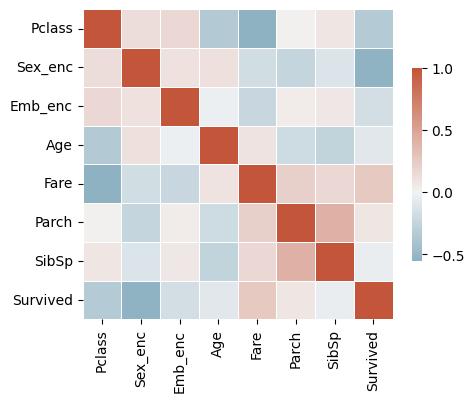

In [57]:
# Calcoliamo la matrice di correlazione
corr = train_data[['Pclass','Sex_enc','Emb_enc','Age','Fare','Parch','SibSp','Survived']].corr()

# creiamo il plot
f, ax = plt.subplots(figsize=(5, 5))

# Creiamo una "Palette divergente" tra due colori per rappresentare
# bene i valori di correlazione positiva e negativa 
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# creiamo una heatmap di tasselli quadrati colorati per
# rappresentare la nostra correlazione e centriamo la
# colormap sul valore 0
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Notiamo un certo grado di mutlicollinearità tra le feature `Parch` e `SiSp` per altro non molto correlate con la nostra etichetta di classe. Decidiamo di sommarle insieme e sommare 1 per fornire una sola feature con la dimensione del nucleo familiare.

In [58]:
train_data.insert(4,'FamilySize',train_data[['Parch','SibSp']].apply(lambda x: np.sum(x)+1,axis=1))

<AxesSubplot: >

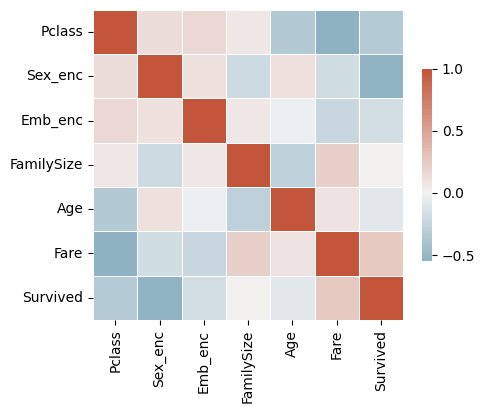

In [59]:
# Calcoliamo la matrice di correlazione
corr = train_data[['Pclass','Sex_enc','Emb_enc','FamilySize','Age','Fare','Survived']].corr()

# creiamo il plot
f, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Notiamo già dalla correlazione che `FamilySize` è comunque poco correlata con la classe e calcoliamo il Fisher Score per aver conferma di poter escludere qquesta feature.

Utilizzeremo una classe di ranking di feature di `sklearn` che si chiama `SelectKBest` e che ci consente di usare una funzione di ranking definita dall'utente. Utilizzeremo una funzione di calcolo del Fisher Score di terze parti, ma compatibile con `SelectKBest`.

In [60]:
X = train_data[['Pclass','Sex_enc','Emb_enc','FamilySize','Age','Fare']].to_numpy()
y = train_data['Survived'].to_numpy()

fisher_ranks = SelectKBest(fisher_score, k=6).fit(X, y)

labels = fisher_ranks.get_feature_names_out(['Pclass','Sex_enc','Emb_enc','FamilySize','Age','Fare'])
scores = fisher_ranks.scores_

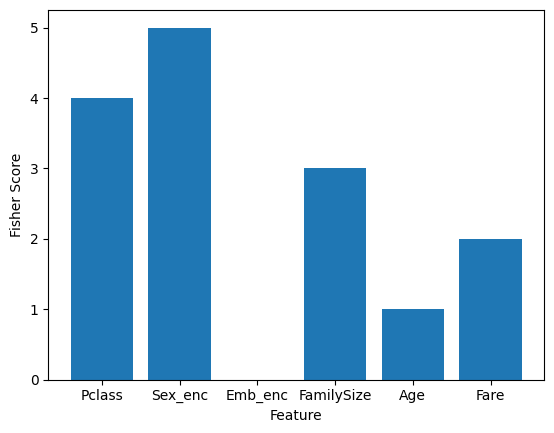

In [61]:
# Mostriamo l'andamento del Fisher score
plt.bar(labels,scores)
plt.xlabel('Feature')
plt.ylabel('Fisher Score')
plt.show()

Rimuoviamo la feature `Emb_enc` che ha il ranking più basso e trasformiamo il data set per effettuare la classificazione.

In [62]:
X_new = SelectKBest(fisher_score, k=5).fit_transform(X, y)

### Addstramento del modello

Effettuiamo lo split del data set per crearci un test set pari al 10% dei nostri dati in modo da poter valutare il modello.

Effettueremo l'addestramento, usando il modello del Gradient Boosting con Decision Tree come base learner, tramite ricerca su una griglia di iperparametri e k-fold cross-validation:

- `validation_fraction`: la porzione di validation set per effettuare l'early stopping
- `subsample`: la frazione casuale di training set usata per addestrare ogni base learner per inserire anche il bagging
- `learning_rate`: il peso con cui il boost all'iterata i-esima tiene conto di quello all'iterata (i-1)-esima

La nostra misura di score sarà l'accuracy, come dice la competizione Kaggle, ma terremo in conto anche altre metriche:

- balanced accuracy
- F1 score
- log-loss ovvero la cross-entropia binaria

Il modello migliore selezionato in termini di accuracy, verrà riaddestrato senza k-fold cross-validation e reso disponibile per le predizioni. Tracceremo l'andamento delle metriche sul test set, rispetto alle iterazioni di boosting.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=42)

# griglia degli iperparametri
params = {
    "n_estimators": [200],    # massimo numero di base learners ovvero di passi di boost
    "validation_fraction": [0.05, 0.075, 0.1],
    "n_iter_no_change": [10], # la 'pazienza' nell'attendere che la metrica migliori sul validation set
    "tol": [0.01],            # tolleranza di variazione della loss di validazione
    "max_depth": [None],      # profondità illimitata per gli alberi dei base learner
    "subsample": [0.5, 0.67, 0.8], 
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "min_samples_leaf": [1],  # nodi foglia anche con un solo campione
    "random_state": [42]      # seme per la permutazione casuale dei campioni per ogni albero
}

# lista delle metrche di score
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1': make_scorer(f1_score), 
           'Bal. acc.': make_scorer(balanced_accuracy_score),
           # la loss richiede le probabilità e non le etichette e poi è meglio quando decresce
           'Log loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
           }

# istanza della griglia di ricerca
grid = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=params,
    scoring=scoring,
    refit='Accuracy',           # Usiamo l'accuracy come misura di addestramento del best model su tutto il data set
    return_train_score=True,    # restituiamo lo score sul training set   
    cv=None                     # default k-fold: 5
)

grid.fit(X_train, y_train)

classifier = grid.best_estimator_

In [64]:
# Stampiamo gli iperparametri selezionati
params = classifier.get_params()

print(f"Validation set: {params['validation_fraction']*100:2.0f}% del data set\n\
Learning rate: {params['learning_rate']}\n\
Frazione di campionamento: {params['subsample']*100:2.0f}% del data set")


Validation set: 10% del data set
Learning rate: 0.05
Frazione di campionamento: 50% del data set


In [65]:
# Stampiamo la performance di addestramento
print(f'Train accuracy: {grid.best_score_:5.4f}')

Train accuracy: 0.8177


Effettuiamo il test e calcoliamo le misure

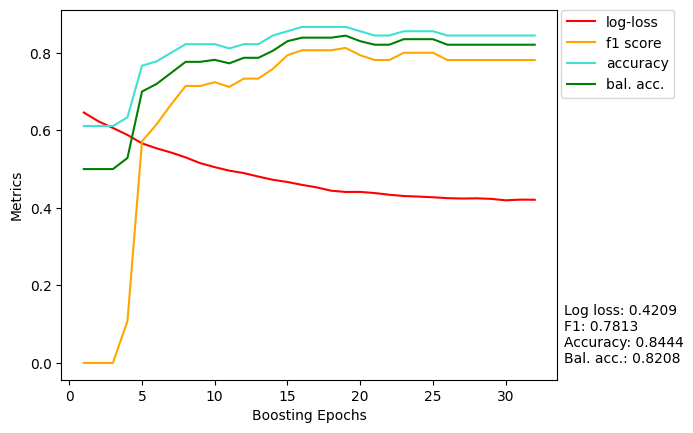

In [66]:
# creiamo il vettore delle ascisse e quello delle etichette

epochs = np.arange(classifier.n_estimators_) + 1
metric_labels = ['log-loss','f1 score','accuracy','bal. acc.']

# creiamo il vettore che conterrà i valori delle metriche
metrics = np.zeros((4, classifier.n_estimators_), dtype=np.float64)

# scandiamo i risultati dei singoli base learner per calcolare l'andamento di ogni metrica
for i, y_proba in enumerate(classifier.staged_predict_proba(X_test)):
    metrics[0,i] = log_loss(y_test, y_proba[:, 1]) # la log-loss vuole le vere probabilità

for i, y_class in enumerate(classifier.staged_predict(X_test)): # lòe altre metriche vogliono le etichette predette
    metrics[1,i] = f1_score(y_test, y_class)
    metrics[2,i] = accuracy_score(y_test, y_class)
    metrics[3,i] = balanced_accuracy_score(y_test, y_class)
    
metrics_string = f'Log loss: {metrics[0,-1]:5.4f}\n\
F1: {metrics[1,-1]:5.4f}\n\
Accuracy: {metrics[2,-1]:5.4f}\n\
Bal. acc.: {metrics[3,-1]:5.4f}'

# Costruiamo il plot delle misure sul test set

plt.plot(epochs, metrics[0], '-', color='red', label=metric_labels[0])
plt.plot(epochs, metrics[1], '-', color='orange', label=metric_labels[1])
plt.plot(epochs, metrics[2], '-', color='turquoise', label=metric_labels[2])
plt.plot(epochs, metrics[3], '-', color='green', label=metric_labels[3])

plt.xlabel('Boosting Epochs')
plt.ylabel('Metrics')
plt.legend(loc="upper right",bbox_to_anchor=(1.25, 1.02))

plt.text(34, 0.0, metrics_string)

plt.show()

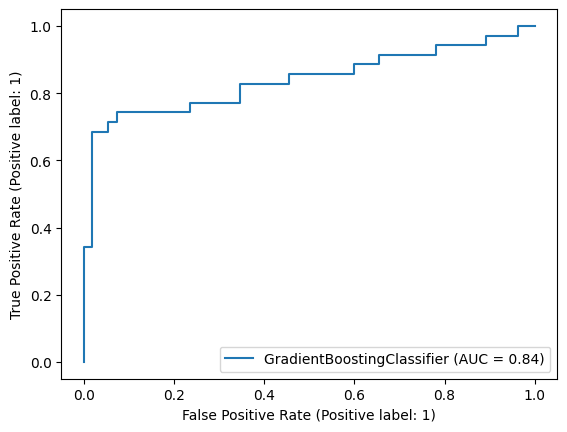

In [67]:
# Mostriamo la ROC sul test set
RocCurveDisplay.from_estimator(classifier, X_test, y_test)
plt.show()

Costruiamo il file di sottomissione dal test set della competizione Kaggle.

In [68]:
# Creiamo le feature numeriche sul test dataframe
test_sex_enc = enc.fit_transform(test_data['Sex'].to_numpy().reshape(-1,1))

test_data.insert(2,'Sex_enc',test_sex_enc)

test_data.insert(4,'FamilySize',test_data[['Parch','SibSp']].apply(lambda x: np.sum(x)+1,axis=1))

X_submission = test_data[['Pclass','Sex_enc','FamilySize','Age','Fare']].to_numpy()

In [70]:
# Facciamo la predizione sul data set di test e salviamo in formato csv
y_submission = classifier.predict(X_submission)

test_data.insert(1,'Survived',y_submission)



ValueError: cannot insert Survived, already exists

In [74]:
test_data.sort_index(inplace=True)

In [84]:
pd.DataFrame(data={'Survived': test_data['Survived']})\
        .to_csv(DATA_HOME+'data/submission.csv')